In [139]:
import json
import random
import string
import datetime
import time
import uuid
import numpy as np

## InsuranceQuoteRequestEvents metrics from baseline and constrained apps

We compute the processing overhead of the baseline (without any constraints applied) and the Constrained solution (a Stream processing application with Stream Constraints applied). Processing overhead in this case refers to time taken from when the event was produced (the appended timestamp to the produced event) to when the event is consumed (the appended timestamp of when the event was consumed).

Another topic is used to collect the event metrics, called the metric-events topic which we then use for analysis. Lakeside Mutual consumers publish metrics to the metric-events topic. An event in this topic is represented as follows:

```java
public class MetricEvent implements DomainEvent {
    private String eventId; // id of the domain event - whether insurance quote or policy
    private Date producedAt; // produced timestamp
    private Date consumedAt; // consumed timestamp
    private String eventType; // the type of event: InsuranceQuoteRequestEvent | InsuranceQuoteRequestEventDuplicate | PolicyCreatedEvent | UpdatePolicyEvent etc
}
```

See the `quotes-metrics-baseline.txt` and `quotes-metrics-constrained.txt` for the metrics data used for analysis. 

In [140]:
def create_event_map(filename):
    events_list = []
    with open(filename, "r") as file:
        for line in file.readlines():
            line_split = line.split(" ")
            events_list.append((line_split[0], line_split[1], line_split[2], line_split[3]))
    events_list.sort(key=lambda x: int(x[1]))
    events_map = {}
    for event in events_list:
        events_map.setdefault(event[0],[]).append((event[3], event[1], event[2]))
    return events_map, events_list

In [141]:
processed_quote_events_baseline, processed_quote_events_baseline_list = create_event_map("quotes-metrics-baseline.txt")
processed_quote_events_constrained, processed_quote_events_constrained_list = create_event_map("quotes-metrics-constrained.txt")

len(list(processed_quote_events_baseline.keys())) 
# number of insurance quote keys generated should be 100

100

## Measuring time taken to process Insurance Quote Request Events baseline

In [142]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import numpy as np
from statistics import mean, median, stdev

In [143]:
events_latency_list = list(processed_quote_events_baseline.values())
events_latency = [item for sublist in events_latency_list for item in sublist]

diffs = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))
diffs.remove(1552) # remove outlier

In [144]:
mean(diffs)

83.31666666666666

In [145]:
median(diffs)

83.0

In [146]:
stdev(diffs)

2.015754559389914

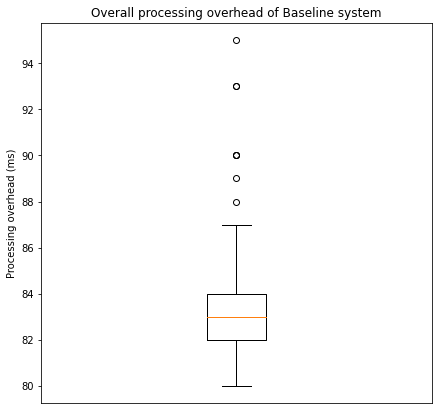

In [147]:
fig = plt.figure(figsize =(7, 7))

# Create plot
plt.boxplot(diffs)
plt.ylabel("Processing overhead (ms)")
plt.xticks([])
plt.title("Processing overhead of Baseline system")

# show plot
plt.show()

fig.savefig("quotes-metrics-baseline-latency.pdf")

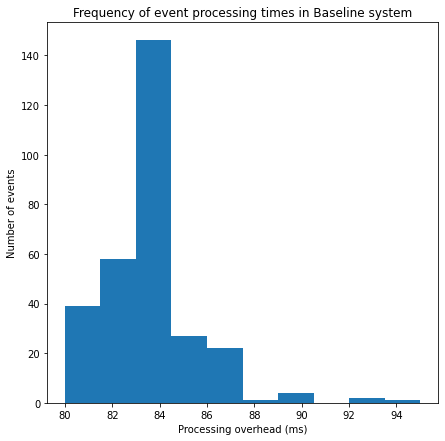

In [148]:
fig = plt.figure(figsize =(7, 7))

# create plot
plt.hist(diffs)
plt.xlabel("Processing overhead (ms)")
plt.ylabel("Number of events")
plt.title("Frequency of event processing times in Baseline system")
  
# show plot
plt.show()

## Measuring time taken to process Insurance Quote Request Events constrained

In [149]:
constrained_events_latency_list = list(processed_quote_events_constrained.values())
constrained_events_latency = [item for sublist in constrained_events_latency_list for item in sublist]

constrained_diffs = list(map(lambda x: int(x[2]) - int(x[1]), constrained_events_latency))
constrained_diffs.remove(1885) # remove outlier

In [150]:
mean(constrained_diffs)

189.71333333333334

In [151]:
median(constrained_diffs)

188.0

In [152]:
stdev(constrained_diffs)

13.968591938992365

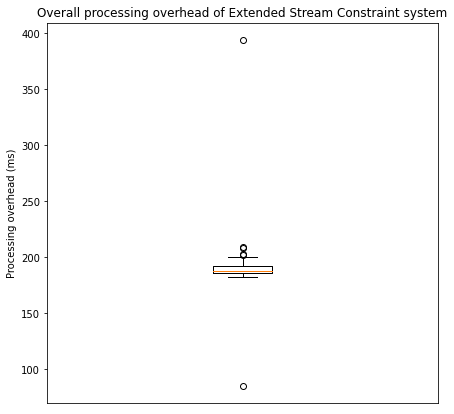

In [153]:
fig = plt.figure(figsize =(7, 7))

# create plot
plt.boxplot(constrained_diffs)
plt.ylabel("Processing overhead (ms)")
plt.xticks([])
plt.title("Overall processing overhead of Extended Stream Constraint system")

# show plot
plt.show()
# can reduce the scale and show outlier
fig.savefig("quotes-metrics-constrained-latency.pdf") 

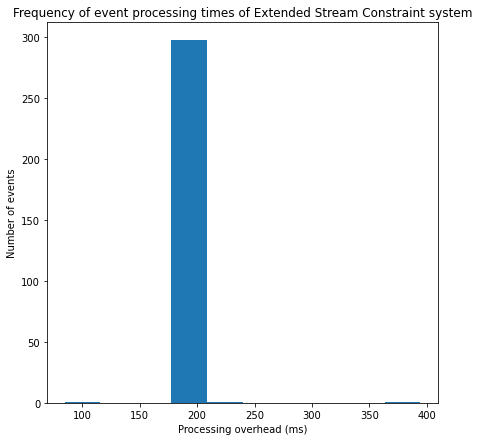

In [154]:
fig = plt.figure(figsize =(7, 7))
  
# create plot
plt.hist(constrained_diffs)
plt.xlabel("Processing overhead (ms)")
plt.ylabel("Number of events")
plt.title("Frequency of event processing times of Extended Stream Constraint system")
  
# show plot
plt.show()

Charts: average of both systems, cummulative time

100


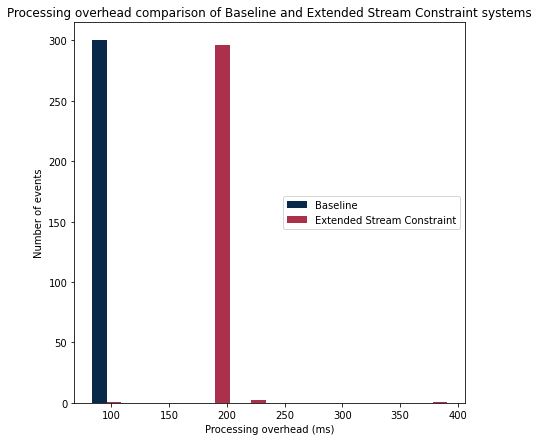

In [155]:
fig = plt.figure(figsize =(7, 7))
  
events = len(processed_quote_events_baseline.values())
print(events)

plt.hist([diffs, constrained_diffs], label=["Baseline", "Extended Stream Constraint"], color=["#082949", "#ab304c"])
plt.legend(loc="right")
plt.xlabel("Processing overhead (ms)")
plt.ylabel("Number of events")
plt.title("Processing overhead comparison of Baseline and Extended Stream Constraint systems")
plt.show()

fig.savefig("quotes-overhead-comparison-bar.pdf")

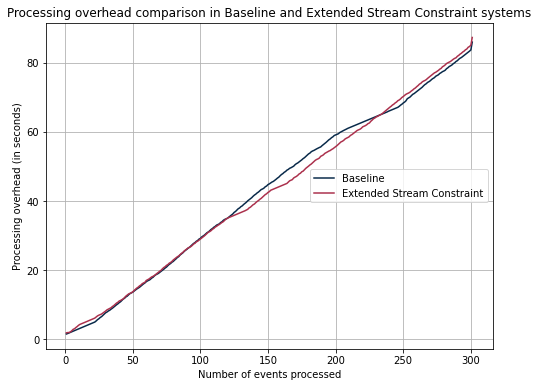

In [157]:
fig = plt.figure(figsize =(8, 6))

baselineStartTimestamp = 1661121285297
constraintStartTimestamp = 1661366468574

cumulative_diffs_y = list(map(lambda x: (int(x[2])-int(baselineStartTimestamp))/1000.0, processed_quote_events_baseline_list))
diffs_x = list(range(1,len(cumulative_diffs_y)+1))

cumulative_constrained_diffs_y = list(map(lambda x: (int(x[2])-int(constraintStartTimestamp))/1000.0, processed_quote_events_constrained_list))
constrained_diffs_x = list(range(1,len(cumulative_constrained_diffs_y)+1))

plt.plot(diffs_x, cumulative_diffs_y, label="Baseline", color="#082949")
plt.plot(constrained_diffs_x, cumulative_constrained_diffs_y, label="Extended Stream Constraint", color="#ab304c")

# n, bins, patches = plt.hist(cumulative_diffs_y, num_bins, histtype="step",
#                            cumulative=True, label="Baseline",  color="#082949")
# patches[0].set_xy(patches[0].get_xy()[:-1])

# n, bins, patches = plt.hist(cumulative_constrained_diffs, num_bins, histtype="step",
#                            cumulative=True, label="Extended Stream Constraint", color="#ab304c")
# patches[0].set_xy(patches[0].get_xy()[:-1])                        

plt.legend(loc="right")
plt.xlabel("Number of events processed")
plt.ylabel("Processing overhead (in seconds)")
plt.grid(True)
plt.title("Processing overhead comparison in Baseline and Extended Stream Constraint systems")
plt.show()

fig.savefig("quotes-comparison.pdf")